In [ ]:
#Import the required packages

import pandas as pd
import os
import nltk, re, pprint
import gensim
import numpy
import csv
import fuzzywuzzy
import time
from datetime import timedelta
from nltk import word_tokenize
from nltk.corpus import stopwords
set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer



In [ ]:
#Setting up the working directory


#Print current working directory
print(os.getcwd())

#Change working directory to desired location
os.chdir("/Users/preshantjoseph/Documents/University/Data Science Master Class 1/Assignment 4")

#Confirm working directory has been changed to desired locatio
print(os.getcwd())

In [ ]:
#Import field of occupation scrape for inputting to model

data = pd.read_csv("occupations.csv", encoding = 'latin1', header = 0)

occ_data = data

data.head(10)

In [ ]:
#Checking for duplicate rows using the page urls 

#1: print all rows where the ID is one of the IDs in duplicated:
pd.reset_option('display.max_colwidth')

URL = data["page"]
Duplicates = data[URL.isin(URL[URL.duplicated()])]

Duplicates

In [ ]:
#Fix UNIT GROUP 2341 AGRICULTURAL AND FORESTRY SCIENTISTS record by concatenating occ text

#select duplicate records related to unit group 2341
occ_text_112 = Duplicates[Duplicates['page'] =="https://www.abs.gov.au/ausstats/abs@.nsf/Latestproducts/B2B7F0A9B46005E3CA2584A8000E7A83?opendocument"]

#Select first record to be base
occ_text_112_fix = occ_text_112.iloc[0,:]

#Combine the occupation text of all three records
occ_text_112_fix['occ_text'] = occ_text_112.iloc[0,2] + occ_text_112.iloc[1,2] + occ_text_112.iloc[2,2]

In [ ]:
#Fix UNIT GROUP 4523 SPORTS COACHES, INSTRUCTORS AND OFFICIALS record by concatenating occ text

#select duplicate records related to unit group 4523
occ_text_331 = Duplicates[Duplicates['page'] =="https://www.abs.gov.au/ausstats/abs@.nsf/Latestproducts/25A2FCFBA49A8022CA2584A8000E7A1A?opendocument"]

#Select first record to be base
occ_text_331_fix = occ_text_331.iloc[0,:]

#Combine the occupation text of both records
occ_text_331_fix['occ_text'] = occ_text_331.iloc[0,2] + occ_text_331.iloc[1,2]

In [ ]:
#Remove duplicate data and reinstert fixed data

#keep the 2341 combined data
keepdata = pd.DataFrame(occ_text_112_fix).T

#Append with combined 4523 data
keepdata = keepdata.append(occ_text_331_fix)

#drop duplicate rows from data set

#drop rows which have 2341 data 
occ_data = occ_data[occ_data.page != 'https://www.abs.gov.au/ausstats/abs@.nsf/Latestproducts/B2B7F0A9B46005E3CA2584A8000E7A83?opendocument']

#drop rows which have 4523 data 
occ_data = occ_data[occ_data.page != 'https://www.abs.gov.au/ausstats/abs@.nsf/Latestproducts/25A2FCFBA49A8022CA2584A8000E7A1A?opendocument']

#append occ data with fixed rows for occupations 2341 and 4523
occ_data = occ_data.append(keepdata)

In [ ]:
#Keep only 4 digit data from scraped data 

#Extract numeric occupation codes from the occ titles

#select occ title column from occ dataframe
occ_titles = occ_data['occ_title']

#loop through occ_titles df to extract all occupation codes
occ_codes = []

for i in occ_titles:
    occ_code = int(''.join(filter(str.isdigit, i)))
    occ_codes.append(occ_code)

#Add occ codes to occ_data data frame
occ_data['occupation code'] = occ_codes
    
    
#Create new column with ANZSCO level

#loop through occ codes to find length of numeric variable and determine ANZSCO classification level
level = []

for i in occ_codes:
    length = len(str(i))
    level.append(length)

#Add ANZSCO classification level to occ_data data frame
occ_data['ANZSCO_classification_level'] = level
 
# Keep only 4 digit occupations to form base of text similarity

occ_data_4dig = occ_data[occ_data.ANZSCO_classification_level == 4]
    

In [ ]:
#Combine occupation titles and scraped occupation text to create associated words for text similarity

occ_text_4digdata = occ_data_4dig
occ_text_4digdata["Associated words"] = occ_data_4dig["occ_title"] + ', ' + occ_data_4dig["occ_text"]


In [ ]:
#Exploratory data analysis on 4 digit occupation dataset

#Preliminary exploration of the text
 
word_token = []
for i in occ_text_4digdata['Associated words']:
    word_token = word_tokenize(i)    

from nltk.probability import FreqDist

fdist = FreqDist(word_token)
print(fdist)

# Frequency Distribution Plot
import matplotlib.pyplot as plt
fdist.plot(34,cumulative=False)
%matplotlib inline
plt.show()


In [ ]:
#Create the dataset for Text similarity analysis

occ4_base_data = occ_text_4digdata[['occupation code', 'Associated words']] #select occupation code and associated words
occ4_spark = occ_text_4digdata[['occupation code', 'Associated words']]

#Convert words to lower case and reduce sparsity
occ4_base_data['Associated words'] = occ4_base_data['Associated words'].str.lower()

occ4_base_data['Associated words'] = occ4_base_data['Associated words'].astype(str)

#Word tokenization
occ4_base_data['Associated words']  = [word_tokenize(row) for row in occ4_base_data['Associated words']]


In [ ]:
#Begin preparing the occupation data

#Text processing the occupation data

start_time = time.monotonic() #timing of code starts

#Lemmatization

#set lemma to call wordnet lemmatizer function
lemma = WordNetLemmatizer()

#Create a function to more easily lemmatize text
def lemma_list(row):
    my_list = row['Associated words']
    lemma_list = [lemma.lemmatize(word) for word in my_list]
    return (lemma_list)

#Using lemmatize function on the associated words text
occ4_base_data['Associated words'] = occ4_base_data.apply(lemma_list, axis = 1)


#Stemming words

#set stemming to call porterstemmer function
stemming = PorterStemmer()

#Create a function to more easily stem words
def stem_list(row):
    my_list = row['Associated words']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

#Apply stemming function on the associated words text
occ4_base_data['Associated words'] = occ4_base_data.apply(stem_list, axis = 1)

#Remove stop words from text

#set stops to call stop words function using english dictionary
stops = set(stopwords.words("english"))                  

#Create a function to more easily remove stop words
def remove_stops(row):
    my_list = row['Associated words']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

#Apply remove stop words function on the associated words text
occ4_base_data['Associated words'] = occ4_base_data.apply(remove_stops, axis=1)

#Remove numbers and punctuation

#Create a function to more easily remove numbers and punctuation
def remove_num_punc(row):
    review = row['Associated words']
    # taken only words (not punctuation)
    token_words = [w for w in review if w.isalpha()]
    return token_words

#Apply remove numbers and punctuation function on the associated words text
occ4_base_data['Associated words'] = occ4_base_data.apply(remove_num_punc, axis=1)

#Create dictionary for text similarity using gensim package
dictionary = gensim.corpora.Dictionary(occ4_base_data['Associated words'])

#Create bag of words
corpus = [dictionary.doc2bow(entry) for entry in occ4_base_data['Associated words']]

#Creating Term Frequency - Inverse Document Frequency (TFIDF)
tf_idf = gensim.models.TfidfModel(corpus)

#Creating similarity measure object
sims = gensim.similarities.Similarity(os.getcwd(),tf_idf[corpus],
                                      num_features=len(dictionary))

#calculating similarities for all 358 occupations at the 4 digit occupation level
occ_doc_tf_idf = tf_idf[corpus]

#Apply similaity measure object to TFIDF
similarities = (sims[occ_doc_tf_idf])


#time measurement
end_time = time.monotonic() #Time measurement finish
print(timedelta(seconds=end_time - start_time)) #print end time




In [ ]:
#Find top 10 occupations with the highest similarity score and return index position

#Return top 11 occupations with highest similarity score for each occupation
idx = (-similarities).argsort(axis = 0)[:11]

#Convert top occupation similarity scores to dataframe
idx_df = pd.DataFrame(idx).T

#Drop the maximum similarity score as this is just the similarity score for its own occupation
idx_df = idx_df.drop(idx_df.columns[0], axis = 1)



In [ ]:
#Create a dictionary to map index values to occupation codes

#Form the base of the dictionary
occ_dictionary = occ_text_4digdata[['occ_title','occupation code']]

#Create an index variable which will correspond with the index variables in idx_df
index = [i for i in range(len(occ_dictionary))]

#Add index variable to the base dictionary which was created
occ_dictionary['index'] = index

#Set the index variable as the dictionary index
occ_dictionary.set_index("index", drop=True, inplace=True) #only run once

#convert dictionary array into actual dictionary setting the index as index
occ_dictionary = occ_dictionary.to_dict(orient="index") #only be run once



In [ ]:
#map all the columns in idx_df to corresponding occ title and occ code
mapped_col0 = idx_df.iloc[:,0].map(occ_dictionary)#remap column 0
mapped_col1 = idx_df.iloc[:,1].map(occ_dictionary)#remap column 1
mapped_col2 = idx_df.iloc[:,2].map(occ_dictionary)#remap column 2
mapped_col3 = idx_df.iloc[:,3].map(occ_dictionary)#remap column 3
mapped_col4 = idx_df.iloc[:,4].map(occ_dictionary)#remap column 4
mapped_col5 = idx_df.iloc[:,5].map(occ_dictionary)#remap column 5
mapped_col6 = idx_df.iloc[:,6].map(occ_dictionary)#remap column 6
mapped_col7 = idx_df.iloc[:,7].map(occ_dictionary)#remap column 7
mapped_col8 = idx_df.iloc[:,8].map(occ_dictionary)#remap column 8
mapped_col9 = idx_df.iloc[:,9].map(occ_dictionary)#remap column 9

#Zip all remapped columns and create a new dataframe which shows top 10 similar occupations for each occupation
Final_occ_matches = pd.DataFrame(zip(mapped_col0, mapped_col1, mapped_col2, mapped_col3, mapped_col4, mapped_col5, mapped_col6, mapped_col7, mapped_col8, mapped_col9))



In [ ]:
#Add Department of Employment, Skills, Small and Family Business employment projections

#read in projections data
projections_data = pd.read_csv('2018 Occupational Projections - five years to May 2023.csv', encoding = 'latin1', header = 0)
 
#list columns in projections data    
list(projections_data.columns)

#remove empty columns
projections_data = projections_data.drop(['Unnamed: 8','Unnamed: 9','Unnamed: 10',
                                          'Unnamed: 11','Unnamed: 12', 'Unnamed: 13',
                                          'Unnamed: 14', 'Unnamed: 15','Unnamed: 16'], axis = 1)
#remove empty rows
projections_data = projections_data.drop(projections_data.index[[667,668,669,670,671,672]])
len(projections_data)

In [149]:
#Example of insights that can be achieved

#Insert the index position of the occupation you want to match with

#Index position for UNIT GROUP 8994 MOTOR VEHICLE PARTS AND ACCESSORIES FITTERS
index_position = 351

#Occupation matches
Most_similar_query = Final_occ_matches.loc[index_position]

#loop through occ_titles df to extract all occupation codes for the most similar occupatons chosen
occ_codes_query = []

for i in range(len(Most_similar_query)):
    a = (Most_similar_query.iloc[i])
    occ_title_a = a['occ_title']
    occ_code_query = int(''.join(filter(str.isdigit, occ_title_a)))
    occ_codes_query.append(occ_code_query)

#Make sure projections Occupation code column is numeric
projections_data['Occupation Code'] = projections_data['Occupation Code'].apply(pd.to_numeric)

#Return occupation codes from top 10 matched occupations
projections_query = projections_data[projections_data['Occupation Code'].isin(occ_codes_query)]

#Generate Chart based on projected employment growth ('000')

projections_chart = projections_query[['Occupation', "Projected employment growth \nfive years to May 2023 - ('000)"]]


In [185]:
#Print most similar occupations for MOTOR VEHICLE PARTS AND ACCESSORIES FITTERS

print("The 10 most similar Occupations for Motor Vehicle Parts and Accessories Fitters:")
print("")

for i in range(len(Most_similar_query)):
    b = (Most_similar_query.iloc[i])
    print(b['occ_title'])

The 10 most similar Occupations for Motor Vehicle Parts and Accessories Fitters:

UNIT GROUP 6213 MOTOR VEHICLE AND VEHICLE PARTS SALESPERSONS

UNIT GROUP 3212 MOTOR MECHANICS

UNIT GROUP 6216 SERVICE STATION ATTENDANTS

UNIT GROUP 8111 CAR DETAILERS

UNIT GROUP 3241 PANELBEATERS

UNIT GROUP 3242 VEHICLE BODY BUILDERS AND TRIMMERS

UNIT GROUP 3211 AUTOMOTIVE ELECTRICIANS

UNIT GROUP 3243 VEHICLE PAINTERS

UNIT GROUP 1494 TRANSPORT SERVICES MANAGERS

UNIT GROUP 3232 METAL FITTERS AND MACHINISTS



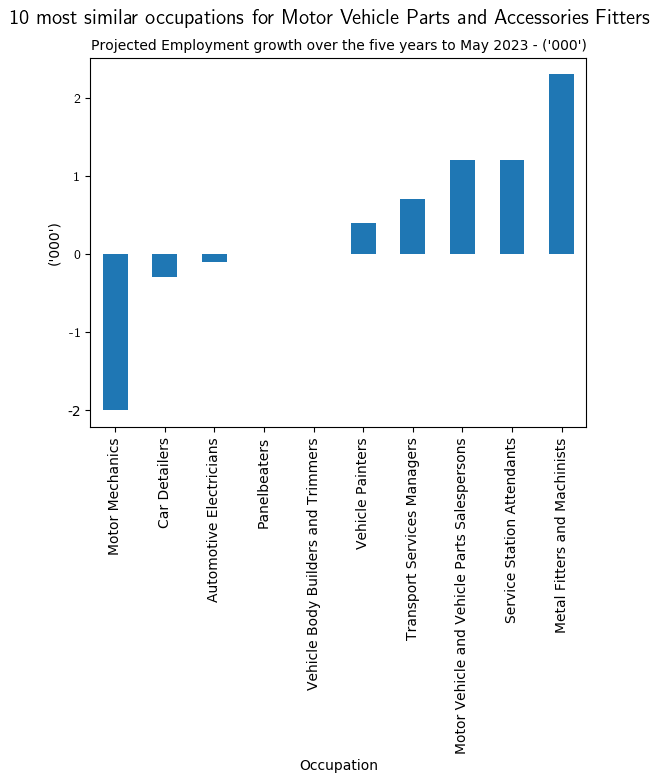

In [178]:
#Plot projections data

projections_chart = projections_chart.sort_values("Projected employment growth \nfive years to May 2023 - ('000)")

#Accuracy rate chart - level 1

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

projections_chart.plot(kind='bar',x='Occupation',y= "Projected employment growth \nfive years to May 2023 - ('000)", legend = False)

plt.ylabel("('000')")
plt.rc('text', usetex=True)

plt.suptitle("10 most similar occupations for Motor Vehicle Parts and Accessories Fitters", fontsize = 15)
plt.title("Projected Employment growth over the five years to May 2023 - ('000')",fontsize = 10)

#plt.title()
#plt.title()

plt.show()

In [ ]:
#

In [ ]:
#Export 4 digit occupation file with cleaned associated words for use with Pyspark
export_csv = occ4_base_data.to_csv (r'occ4_spark.csv', index = None, header=True, doublequote = True) #Don't forget to add '.csv' at the end of the path
export_csv = occ4_base_data.to_csv (r'occ4_spark.txt', index = None, header=True ) #Don't forget to add '.csv' at the end of the path


export_csv = occ4_spark.to_csv (r'occ4_spark_full.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path




In [ ]:
from pyspark import SparkContext, SparkConf #actually use
from operator import add #Actually use
from pyspark.ml.feature import HashingTF, IDF, Tokenizer# actualy use
from pyspark.sql.functions import col, split



from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import pandas as pd
import re
import string

In [ ]:
#Start spark session
sc.stop()
conf = SparkConf()\
        .setAppName("Occupation_query")\
        .setMaster("local[*]")\
        .set("spark.driver.memory", "10g")\
        .set("spark.driver.maxResultSize", "4g")

sc = SparkContext(conf=conf)




In [ ]:
#load the dataset into spark
spark = SparkSession.builder.master('yarn-client').appName('Occupation_query_ds').getOrCreate()


#Set schema for spark to attach to loaded data
schema = StructType([
    StructField("occupation code", IntegerType(), True),
    StructField("Associated words", StringType(), True)])

    
#ArrayType(StructType([StructField("Associated words", StringType()), True)]))

#Read 4 digit occupation file with cleaned associated words into spark
data_occ_spark = (spark.read.csv("/Users/preshantjoseph/Documents/University/Data Science Master Class 1/Assignment 4/occ4_spark.csv", 
                                 header = True, mode="DROPMALFORMED", schema = schema
                                ))


data_occ_spark.withColumn(
    "Associated words",
    split(col("Associated words"), ",\s*").cast("array<string>").alias("Associated words")
)

data_occ_spark.show(10)

In [ ]:
sc.stop()
sc = SparkContext(conf=conf)
rawData = data_occ_spark


#documents = rawData.map(lambda line : line.split('\t')[1].split())
#docs = essays.map(lambda (filename, contents): contents)


#documents = rawData.map(lambda line : line.split('\t')[1].split())
#titles = rawData.map(lambda line : line.split('\t')[0])
#titles.cache()

tokenizer = Tokenizer(inputCol="Associated words", outputCol="words")
wordsData = tokenizer.transform(data_occ_spark)

hashingTF = HashingTF(inputCol= "words", outputCol="rawFeatures", numFeatures=20) #20 Million hash buckets just to make sure it fits in memory
featurizedData = hashingTF.transform(wordsData)

featurizedData.cache()

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
#rescaledData = idfModel.transform(tf)

#rescaledData.select("label", "features").show()


In [ ]:
QueryTF = hashingTF.transform(["Motor Vehicle"])
QueryHashValue = QueryTF.indices[0]
QueryRelevance = idfModel.map(lambda x: x[QueryHashValue])
zippedResults = QueryRelevance.zip(titles)
print "Top 10 related documents:"
for (k, v) in zippedResults.sortByKey(ascending=False).take(10):
    print v


In [ ]:
tf.show(n=2)

In [ ]:
#rawData = sc.textFile(r"/Users/preshantjoseph/Documents/University/Data Science Master Class 1/Assignment 4/occ4_base_data.txt")

from pyspark.sql import functions as F

documents = sc.textFile("/Users/preshantjoseph/Documents/University/Data Science Master Class 1/Assignment 4/occ4_base_data.txt").map(lambda line: line.split("  "))
#titles = rawData.map(lambda line : line.split('\t')[0])
#titles.cache()

#documents.take(1)
hashingTF = HashingTF(numFeatures = 20000000)  #20 Million hash buckets just to make sure it fits in memory
tf = hashingTF.transform(documents)
#idf = IDF(minDocFreq=10).fit(tf)
#tfidf = idf.transform(tf)
#tfidf.cache()